# Getting familiar with the project..

## Project Description

<font color='green'><b>* </b></font>In this project, we will take on the task of emotion detection, where your input is a sentence, and the goal is to predict one label with the emotion expressed in that sentence. <br>
<font color='green'><b>* </b></font> We will use a subset of the XED dataset for multiclass emotion detection <font color='green'><b>[1]</b></font>, which consists of English and Finnish movie subtitles from OPUS corpus <font color='green'><b>[2] </b></font>, annotated with emotional polarity and discrete emotions. <br>
<font color='green'><b>* </b></font> The XED dataset originally contains multilabel annotations for discrete emotions, but to keep things simpler, we will provide a single label dataset, extracted from the English dataset, where each example looks like this: <br>


```
You will help our medical research and thereby saving thousands of lives . 8
```

The sentence and the label are separated by a tab character (\t), and the labels are mapped
as follows:<br>
<font color='green'>1.</font> Anger <br>
<font color='green'>2.</font> Anticipation<br>
<font color='green'>3.</font> Digust<br>
<font color='green'>4.</font> Fear<br>
<font color='green'>5.</font> Joy<br>
<font color='green'>6.</font> Sadness<br>
<font color='green'>7.</font> Surprise<br>
<font color='green'>8.</font> Trust<br>

<font color='green'><b>* </b></font> The project will simulate an evaluation forum. Evaluation forums are competitions in which participants test their systems in specific tasks, in the same conditions. Training and/or
development sets are provided in advance. On a certain predefined date, a test set is released. Then, participants have a short period of time to return the output of their systems, which is evaluated and straightforwardly compared with one another, resulting in a final ranking where the state-of-the-art system is acknowledged. <br>
<font color='green'><b>* </b></font> Thus, we will provide the training and development sets right away, and your assignment is to create (at least) one approach that, given each sentence, will predict an emotion label from 1
to 8. You can use the training set to train your model and to inspect as you wish, and you should use the development set to have a sense of how well your model is doing, as well as to report the performance of your model in the report.<br><br>
<font color='green'><b>* </b></font> Closer to the deadline, we will release a test set without the emotion labels. Upon running your model on the test set, you should output a file with the original (i.e., not preprocessed)
sentences followed by the label your model predicted (in the same format of the training and development sets, i.e.: ```sentence\tlabel```). We will then compare that output file with the original test set and obtain the accuracy <font color='green'><b>(using scikit-learn [3])</b></font> as part of the evaluation
process.





## Approaches

Just like pretty much every other NLP task, this is an active area of research, so there is no “right solution” for this problem. You can create your model however you wish, as long as you do not look at the test set. Possible approaches might include: <br><br>
<font color='green'><b>* </b></font>**Rule-based approaches** (although these are likely to be weak by themselves) <br>
<font color='green'><b>* </b></font>**Approaches based on additional resources** (e.g., emotion knowledge bases)<br>
<font color='green'><b>* </b></font>**Models based on distances/similarity metrics**<br>
<font color='green'><b>* </b></font>**Language models** (i.e., based on n-grams)<br>
<font color='green'><b>* </b></font>**Machine learning models** (e.g., KNN, Naïve Bayes, SVC, etc.)<br><br>
You can also extract whatever features you wish from the sentences, and of course, apply whatever preprocessing you find relevant. Note that whatever preprocessing you apply to the training set must be applied to the development set (and test set, upon release) as well!<br>
You can try as many approaches as you wish and even mix multiple approaches into one. You only need to submit the code for the best approach (i.e., the one that obtained the best accuracy in the development set). You only need to report that approach against a baseline (a weaker approach you tried).<br>
The project should be done in Python 3. Naturally, you can (and should) use available libraries, such as pandas, scikit-learn, etc. Just make sure to properly credit everything you use in the report. Also, while the approaches you try are likely to have already been tried by someone
else, you should not plagiarize anyone’s code. 

## References

<font color='green'>**1.** </font> Öhman, E., Pàmies, M., Kajava, K. and Tiedemann, J., 2020. XED: A Multilingual
Dataset for Sentiment Analysis and Emotion Detection. In Proceedings of the 28th
International Conference on Computational Linguistics (COLING 2020). <br>
<font color='green'>**2.** </font>Lison, P., and Tiedemann, J., 2016. OpenSubtitles2016: Extracting Large Parallel Corpora from Movie and TV Subtitles. In Proceedings of the 10th International Conference on Language Resources and Evaluation (LREC 2016)<br>
<font color='green'>**3.** </font> Pedregosa et al., 2011. Scikit-learn: Machine Learning in Python, in Journal of Machine Learning Research 12, pp. 2825-2830.

# Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#baseline preprocessing
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import re

In [2]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 128

In [3]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

# Loading Data

In [4]:
url1 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/dev_set.txt'
dev_set = pd.read_csv(url1, delimiter='\t')
dev_set

,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7
3,I'm just a little anxious to get up there and ...,2
4,Did you think we don't know about your affair ...,1
...,...,...
995,All I ask of you is be careful .,4
996,"You don't like jazz , pal ?",7
997,Put it on .,1
998,Can you ever imagine [PERSON] being in a spot ...,7


In [5]:
url2 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/training_set.txt'
train_set = pd.read_csv(url2, delimiter='\t')
train_set

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1
...,...,...
13995,"Yes , Commissioner .",8
13996,The ring !,7
13997,That is my greatest and most enduring love .,5
13998,"When I came back from the war , I had a son .",5


# Baseline Preprocessing

In [6]:
## Uncomment these on first run
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')


In [7]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()


In [8]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def baseline_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words
        - use stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
    
    ## Remove the extra space left before symbols
    ## e.g. "who are you ?" >> "who are you?"
    ## Not sure if this should be done, comment out if not
    df[col] = df[col].apply(lambda x: str.replace(x,' ?','?'))
    df[col] = df[col].apply(lambda x: str.replace(x,' !','!'))

    
    ## Remove stop words ?
    ## https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
    
    if len(stop) > 0:
        df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop)]))
    
    ## Use Stemmer
    df[col] = df[col].apply(lambda x: stem_sentences(x) )
    
    ## Remove excess space
    df[col] = df[col].str.strip()
    
    return df

In [9]:
train_set_prep = baseline_preprocessing(train_set, 'sentence', stop)
train_set_prep.head(3)

,sentence,emotion,original
0,im old trade,6,I'm too old to be traded in .
1,mother said tell ladi hand,8,Mother said you could always tell a lady by he...
2,said id leav time came,6,I always said I'd leave off when the time came .


In [10]:
#stop

In [11]:
dev_set_prep = baseline_preprocessing(dev_set, 'sentence', stop)
dev_set_prep.head(3)

,sentence,emotion,original
0,happen gold safe?,4,What happens to the gold in our safe ?
1,natur cold feet,8,Natural to get cold feet .
2,lucki he?,7,"Not very lucky , is he ?"


In [12]:
count_chars = train_set_prep.copy()
count_chars['len'] = count_chars[['sentence']].astype(str).sum(axis=1).str.len()
count_chars['len'].describe()
count_chars.loc[count_chars['len']==0,:]

,sentence,emotion,original,len
163,,4,"Get her back for me , please .",0
446,,2,Me too .,0
454,,5,It was always you and me .,0
844,,2,There can be ...,0
1210,,2,"Mine , mine , mine , mine , mine , mine ...",0
...,...,...,...,...
13226,,1,Out .,0
13243,,5,I can do anything .,0
13573,,1,"No , we're not done but you are .",0
13619,,1,You ...,0


# Data Understanding

In [13]:
labels = [
    (1, 'Anger'),
    (2, 'Anticipation'),
    (3, 'Digust'),
    (4, 'Fear'),
    (5, 'Joy'),
    (6, 'Sadness'),
    (7, 'Surprise'),
    (8, 'Trust'),
]

In [14]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['emotion']

X_test = dev_set_prep['sentence']
Y_test = dev_set_prep['emotion']

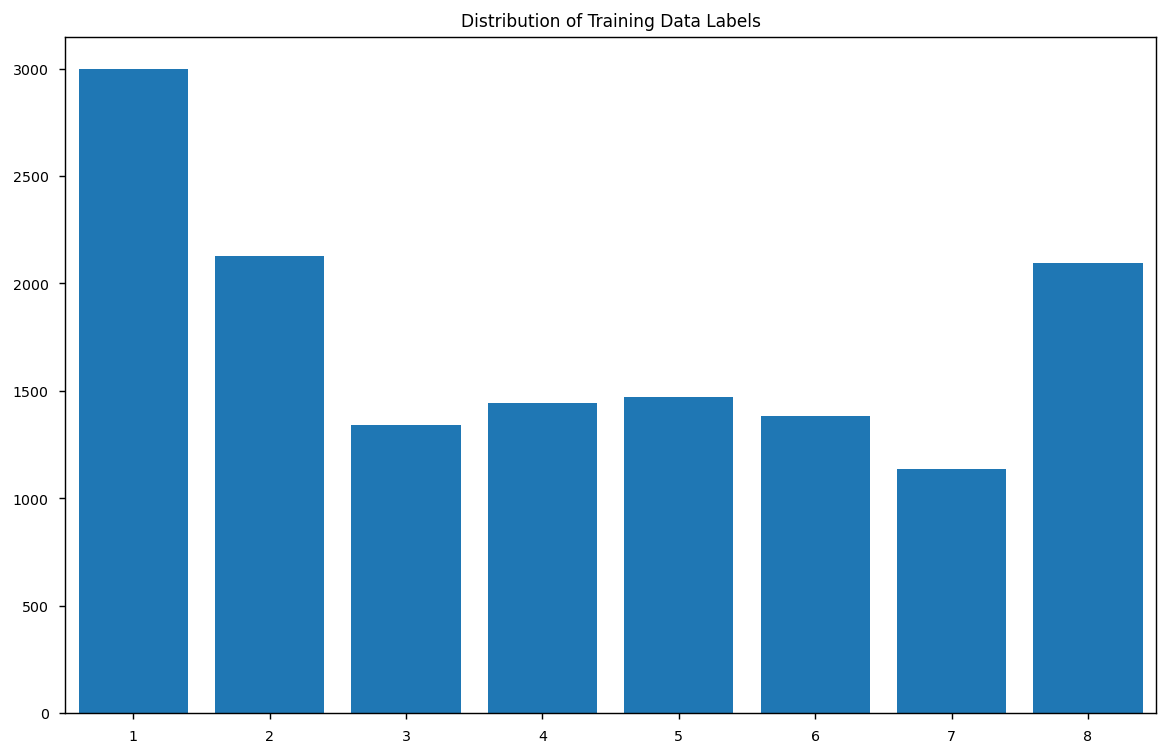

In [15]:
fig, ax = plt.subplots(figsize=(11,7))
y_counts = np.bincount(Y_train)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Training Data Labels")
plt.show()

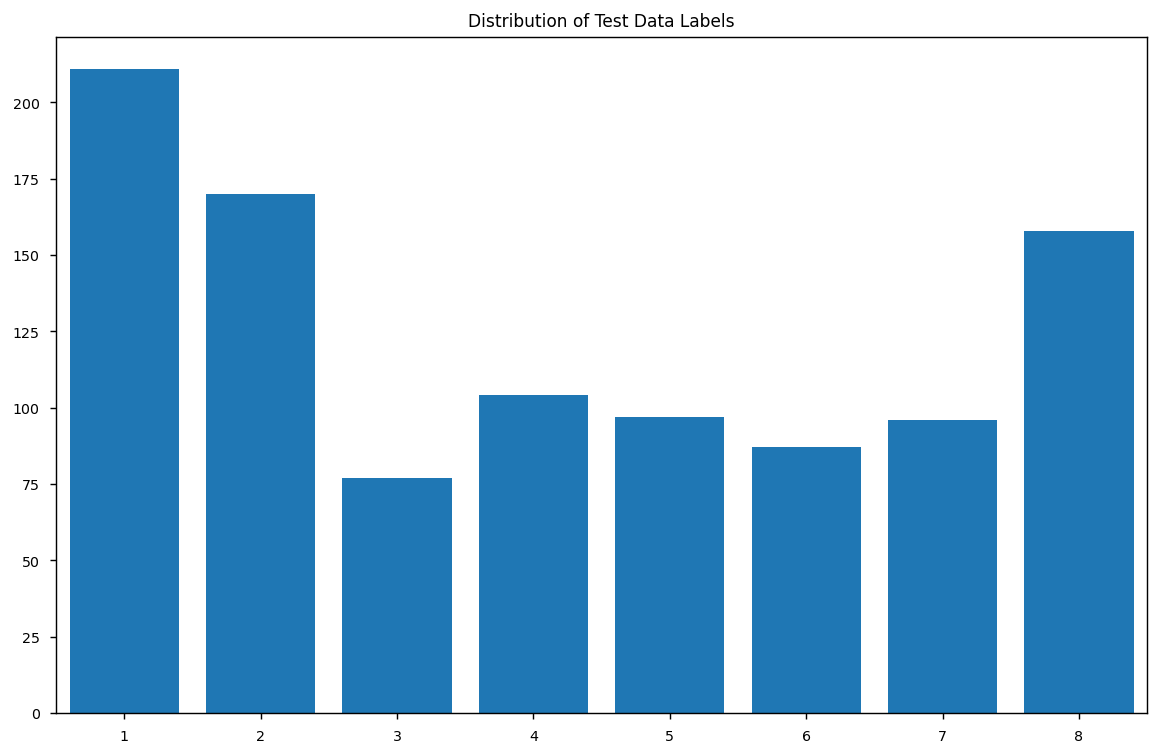

In [16]:
fig, ax = plt.subplots(figsize=(11,7))
y_counts = np.bincount(Y_test)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Test Data Labels")
plt.show()

# Data Transformation

In [17]:
vect = CountVectorizer(stop_words='english', ngram_range=(1,2))
X = vect.fit_transform(count_chars["original"])
y = np.array(count_chars["emotion"])


In [18]:
X.shape

(14000, 31786)

# Model Selection

In [19]:
def get_scores(preds, label, cv_score, Y=Y_test):
    s_ = pd.DataFrame([[label,
               accuracy_score(preds,Y),
               f1_score(preds,Y, average='weighted'),
               recall_score(preds,Y, average='weighted'),
               cv_score                
            ]],
             columns=["Model", "Accuracy", "F1", "Recall", "CrossValAccuracy"])
    return s_

In [20]:
score_func = 'accuracy'

## MNB

In [21]:
pipe_mnb = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

## Uses values of default params as grid search values
grid_mnb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "classifier__alpha": [1]
}

mnbgs = GridSearchCV(pipe_mnb, grid_mnb, n_jobs=-1, cv=10, scoring=score_func)

mnbgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % mnbgs.best_score_)
print(mnbgs.best_params_)


mnbgs_pred = mnbgs.predict(X_test)

print("Baseline Accuracy:    ", accuracy_score(mnbgs_pred,Y_test))
print("Baseline Weighted F1: ", f1_score(mnbgs_pred,Y_test, average='weighted'))

Best parameters (CV score=0.346):
{'classifier__alpha': 1, 'count__ngram_range': (1, 1), 'count__stop_words': None}
Baseline Accuracy:     0.351
Baseline Weighted F1:  0.38428217874183407


In [22]:
scores = get_scores(mnbgs_pred, "MultinomialNB", mnbgs.best_score_)

In [23]:
base_pipe_opt = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

base_grid = {
    "count__ngram_range": [(1,1), (2,2), (3,3)],
    "count__stop_words": ["english", None],
    "classifier__alpha": [.25,.3,.4,.5,.6,.75,1]
}

base_search = GridSearchCV(base_pipe_opt, base_grid, n_jobs=-1, cv=10, scoring=score_func)

base_search.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % base_search.best_score_)
print(base_search.best_params_)


base_search_pred = base_search.predict(X_test)

print("Baseline Accuracy:    ", accuracy_score(base_search_pred,Y_test))
print("Baseline Weighted F1: ", f1_score(base_search_pred,Y_test, average='weighted'))

Best parameters (CV score=0.350):
{'classifier__alpha': 0.4, 'count__ngram_range': (1, 1), 'count__stop_words': None}
Baseline Accuracy:     0.347
Baseline Weighted F1:  0.363997793826224


In [24]:
scores = pd.concat([scores, get_scores(base_search_pred, "MultinomialNB2", base_search.best_score_)])
scores

,Model,Accuracy,F1,Recall,CrossValAccuracy
0,MultinomialNB,0.351,0.384282,0.351,0.345643
0,MultinomialNB2,0.347,0.363998,0.347,0.350071


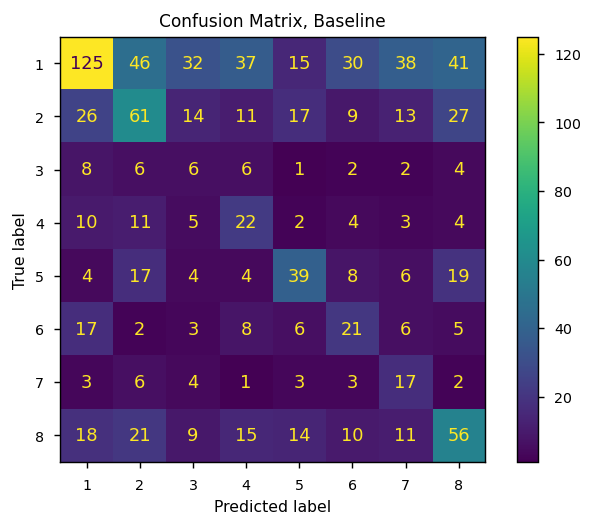

In [25]:
cm = confusion_matrix(base_search_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=base_search.classes_)
disp.plot()
plt.title("Confusion Matrix, Baseline")
plt.show()

## MNB + TfIdf 

In [26]:
mnbtf_pipe = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

mnbtf_grid = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
    "classifier__alpha": [.25,.3,.4,.5,.6,.75,1]
}

mnbtf_gs = GridSearchCV(mnbtf_pipe, mnbtf_grid, n_jobs=-1, cv=10, scoring=score_func)

mnbtf_gs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % mnbtf_gs.best_score_)
print(mnbtf_gs.best_params_)


mnbtf_gs_pred = mnbtf_gs.predict(X_test)

print("Accuracy:    ", accuracy_score(mnbtf_gs_pred,Y_test))
print("Weighted F1: ", f1_score(mnbtf_gs_pred,Y_test, average='weighted'))

scores = pd.concat([scores, get_scores(mnbtf_gs_pred, "MultinomialNB_TFIDF", mnbtf_gs.best_score_)])


Best parameters (CV score=0.343):
{'classifier__alpha': 0.25, 'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.334
Weighted F1:  0.36102856543076633


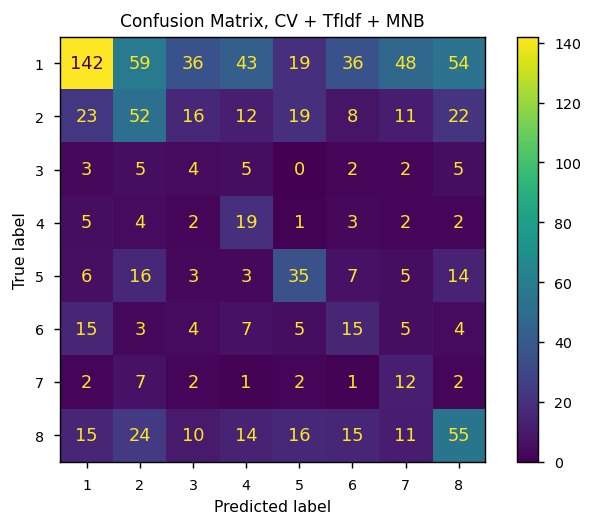

In [27]:
cm_tf = confusion_matrix(mnbtf_gs_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tf,
                              display_labels=mnbtf_gs.classes_)
disp.plot()
plt.title("Confusion Matrix, CV + TfIdf + MNB")
plt.show()

## SGD

In [28]:
from sklearn.linear_model import SGDClassifier

base_pipe_sgd = Pipeline([
    ('count', CountVectorizer()),
    ('classifier', SGDClassifier(random_state=RANDOM_STATE, max_iter=1000)),
])

grid_sgd = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
}

sgdc = GridSearchCV(base_pipe_sgd, grid_sgd, n_jobs=-1, cv=10, scoring=score_func)

sgdc.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % sgdc.best_score_)
print(sgdc.best_params_)


sgdc_pred = sgdc.predict(X_test)

print("Accuracy:    ", accuracy_score(sgdc_pred,Y_test))
print("Weighted F1: ", f1_score(sgdc_pred,Y_test, average='weighted'))

scores = pd.concat([scores, get_scores(sgdc_pred, "SGDClassifier", sgdc.best_score_)])


Best parameters (CV score=0.337):
{'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.325
Weighted F1:  0.3313594415406982


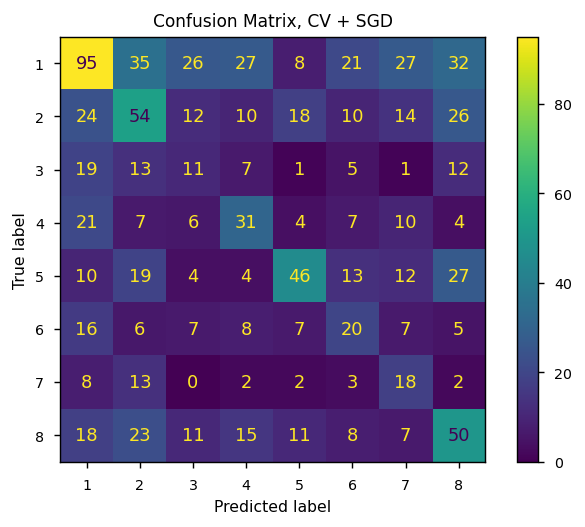

In [29]:
cm_sg = confusion_matrix(sgdc_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sg,
                              display_labels=sgdc.classes_)
disp.plot()
plt.title("Confusion Matrix, CV + SGD")
plt.show()

## LR

In [30]:
from sklearn.linear_model import LogisticRegression


In [31]:

pipe_lr = Pipeline([
    ('count', CountVectorizer()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)),
])

grid_lr = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
}

lrgs = GridSearchCV(pipe_lr, grid_lr, n_jobs=-1, cv=10, scoring=score_func)

lrgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % lrgs.best_score_)
print(lrgs.best_params_)


lrgs_pred = lrgs.predict(X_test)

print("Accuracy:    ", accuracy_score(lrgs_pred,Y_test))
print("Weighted F1: ", f1_score(lrgs_pred,Y_test, average='weighted'))

scores = pd.concat([scores, get_scores(lrgs_pred, "LogisticRegression", lrgs.best_score_)])


Best parameters (CV score=0.357):
{'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.35
Weighted F1:  0.36153582881525015


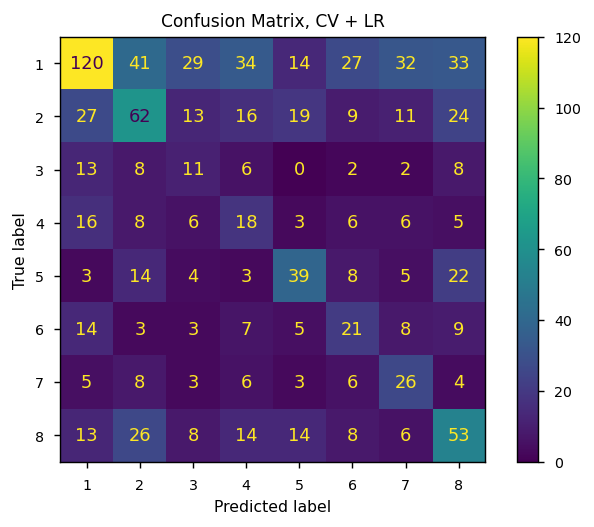

In [32]:
cm_lr = confusion_matrix(lrgs_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lrgs.classes_)
disp.plot()
plt.title("Confusion Matrix, CV + LR")
plt.show()

## DT

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2

In [34]:

pipe_dt = Pipeline([
    ('count', CountVectorizer()),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

grid_dt = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None]
}

dtgs = GridSearchCV(pipe_dt, grid_dt, n_jobs=-1, cv=10, scoring=score_func)

dtgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % dtgs.best_score_)
print(dtgs.best_params_)


dtgs_pred = dtgs.predict(X_test)

print("Accuracy:    ", accuracy_score(dtgs_pred,Y_test))
print("Weighted F1: ", f1_score(dtgs_pred,Y_test, average='weighted'))

scores = pd.concat([scores, get_scores(dtgs_pred, "DecisionTreeClassifier", dtgs.best_score_)])


Best parameters (CV score=0.293):
{'count__ngram_range': (1, 1), 'count__stop_words': 'english'}
Accuracy:     0.304
Weighted F1:  0.3131344960170522


In [35]:
CountVectorizer().fit_transform(X_train).shape

(14000, 5825)

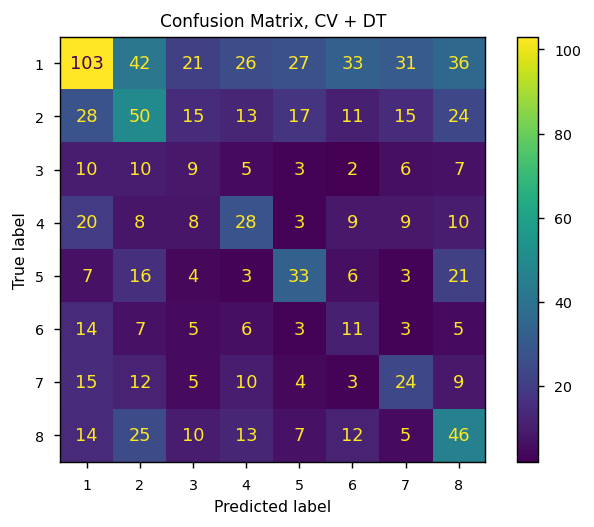

In [36]:
cm_dt = confusion_matrix(dtgs_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                              display_labels=lrgs.classes_)
disp.plot()
plt.title("Confusion Matrix, CV + DT")
plt.show()

## VotingClassifier

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)), 
                ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE)), 
                ('nb', MultinomialNB()),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

vcgs = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

vcgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % vcgs.best_score_)
print(vcgs.best_params_)


vcgs_pred = vcgs.predict(X_test)

print("Accuracy:    ", accuracy_score(vcgs_pred,Y_test))
print("Weighted F1: ", f1_score(vcgs_pred,Y_test, average='weighted'))


Best parameters (CV score=0.356):
{'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.354
Weighted F1:  0.37688704920255306


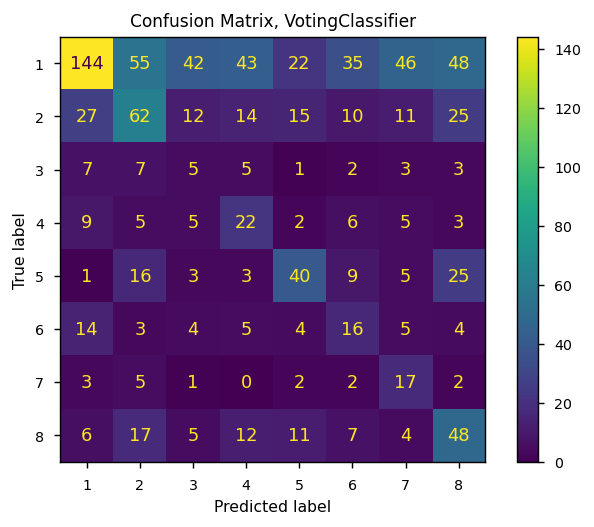

In [40]:
cm_vc = confusion_matrix(vcgs_pred,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vc,
                              display_labels=lrgs.classes_)
disp.plot()
plt.title("Confusion Matrix, VotingClassifier")
plt.show()

In [41]:
scores = pd.concat([scores, get_scores(vcgs_pred, "VotingClassifier", vcgs.best_score_)])

## GB

In [42]:

pipe_gb = Pipeline([
    ('count', CountVectorizer()),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

grid_gb = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None]
}

gbgs = GridSearchCV(pipe_gb, grid_gb, n_jobs=-1, cv=10, scoring=score_func)

gbgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % gbgs.best_score_)
print(gbgs.best_params_)


gbgs_pred = gbgs.predict(X_test)

print("Accuracy:    ", accuracy_score(gbgs_pred,Y_test))
print("Weighted F1: ", f1_score(gbgs_pred,Y_test, average='weighted'))

scores = pd.concat([scores, get_scores(gbgs_pred, "GradientBoostingClassifier", gbgs.best_score_)])


Best parameters (CV score=0.319):
{'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.327
Weighted F1:  0.3640324634423181


In [43]:
print("Accuracy:    ", accuracy_score(gbgs_pred,Y_test))
print("Weighted F1: ", f1_score(gbgs_pred,Y_test, average='weighted'))
print("Recall:      ", recall_score(gbgs_pred,Y_test, average='weighted'))


Accuracy:     0.327
Weighted F1:  0.3640324634423181
Recall:       0.327


In [44]:
X_train.shape[0]*.0005

7.0

## SVM

In [45]:

pipe_svc = Pipeline([
    ('count', CountVectorizer()),
    ('svc', SVC(random_state=RANDOM_STATE)),
])

grid_svc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

svcgs = GridSearchCV(pipe_svc, grid_svc, n_jobs=-1, cv=10, scoring=score_func)

svcgs.fit(X_train, Y_train)
print("Best parameters (CV score=%0.3f):" % svcgs.best_score_)
print(svcgs.best_params_)


svcgs_pred = svcgs.predict(X_test)

print("Accuracy:    ", accuracy_score(svcgs_pred,Y_test))
print("Weighted F1: ", f1_score(svcgs_pred,Y_test, average='weighted'))



Best parameters (CV score=0.348):
{'count__ngram_range': (1, 1), 'count__stop_words': None}
Accuracy:     0.346
Weighted F1:  0.3791612676782831


In [46]:
scores = pd.concat([scores, get_scores(svcgs_pred, "SVM", svcgs.best_score_)])

In [47]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy,F1,Recall,CrossValAccuracy
0,VotingClassifier,0.354,0.376887,0.354,0.355643
1,MultinomialNB,0.351,0.384282,0.351,0.345643
2,LogisticRegression,0.350,0.361536,0.350,0.357143
3,MultinomialNB2,0.347,0.363998,0.347,0.350071
4,SVM,0.346,0.379161,0.346,0.348357
5,MultinomialNB_TFIDF,0.334,0.361029,0.334,0.342571
6,GradientBoostingClassifier,0.327,0.364032,0.327,0.318571
7,SGDClassifier,0.325,0.331359,0.325,0.337500
8,DecisionTreeClassifier,0.304,0.313134,0.304,0.293000


# UMAP

In [48]:
import umap
import umap.plot

In [49]:
cv_umap = TfidfVectorizer(min_df=.0005, ngram_range=(1,1))
umap_vec = cv_umap.fit_transform(X_train)

In [58]:
embedding = umap.UMAP(n_components=2, metric='jaccard', 
                      min_dist=0.01, 
                      n_neighbors=15,).fit_transform(umap_vec)

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 40009 edges.
It has fully disconnected 1928 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/metrics

In [59]:
u_plot = pd.DataFrame(embedding)
u_plot['label'] = Y_train

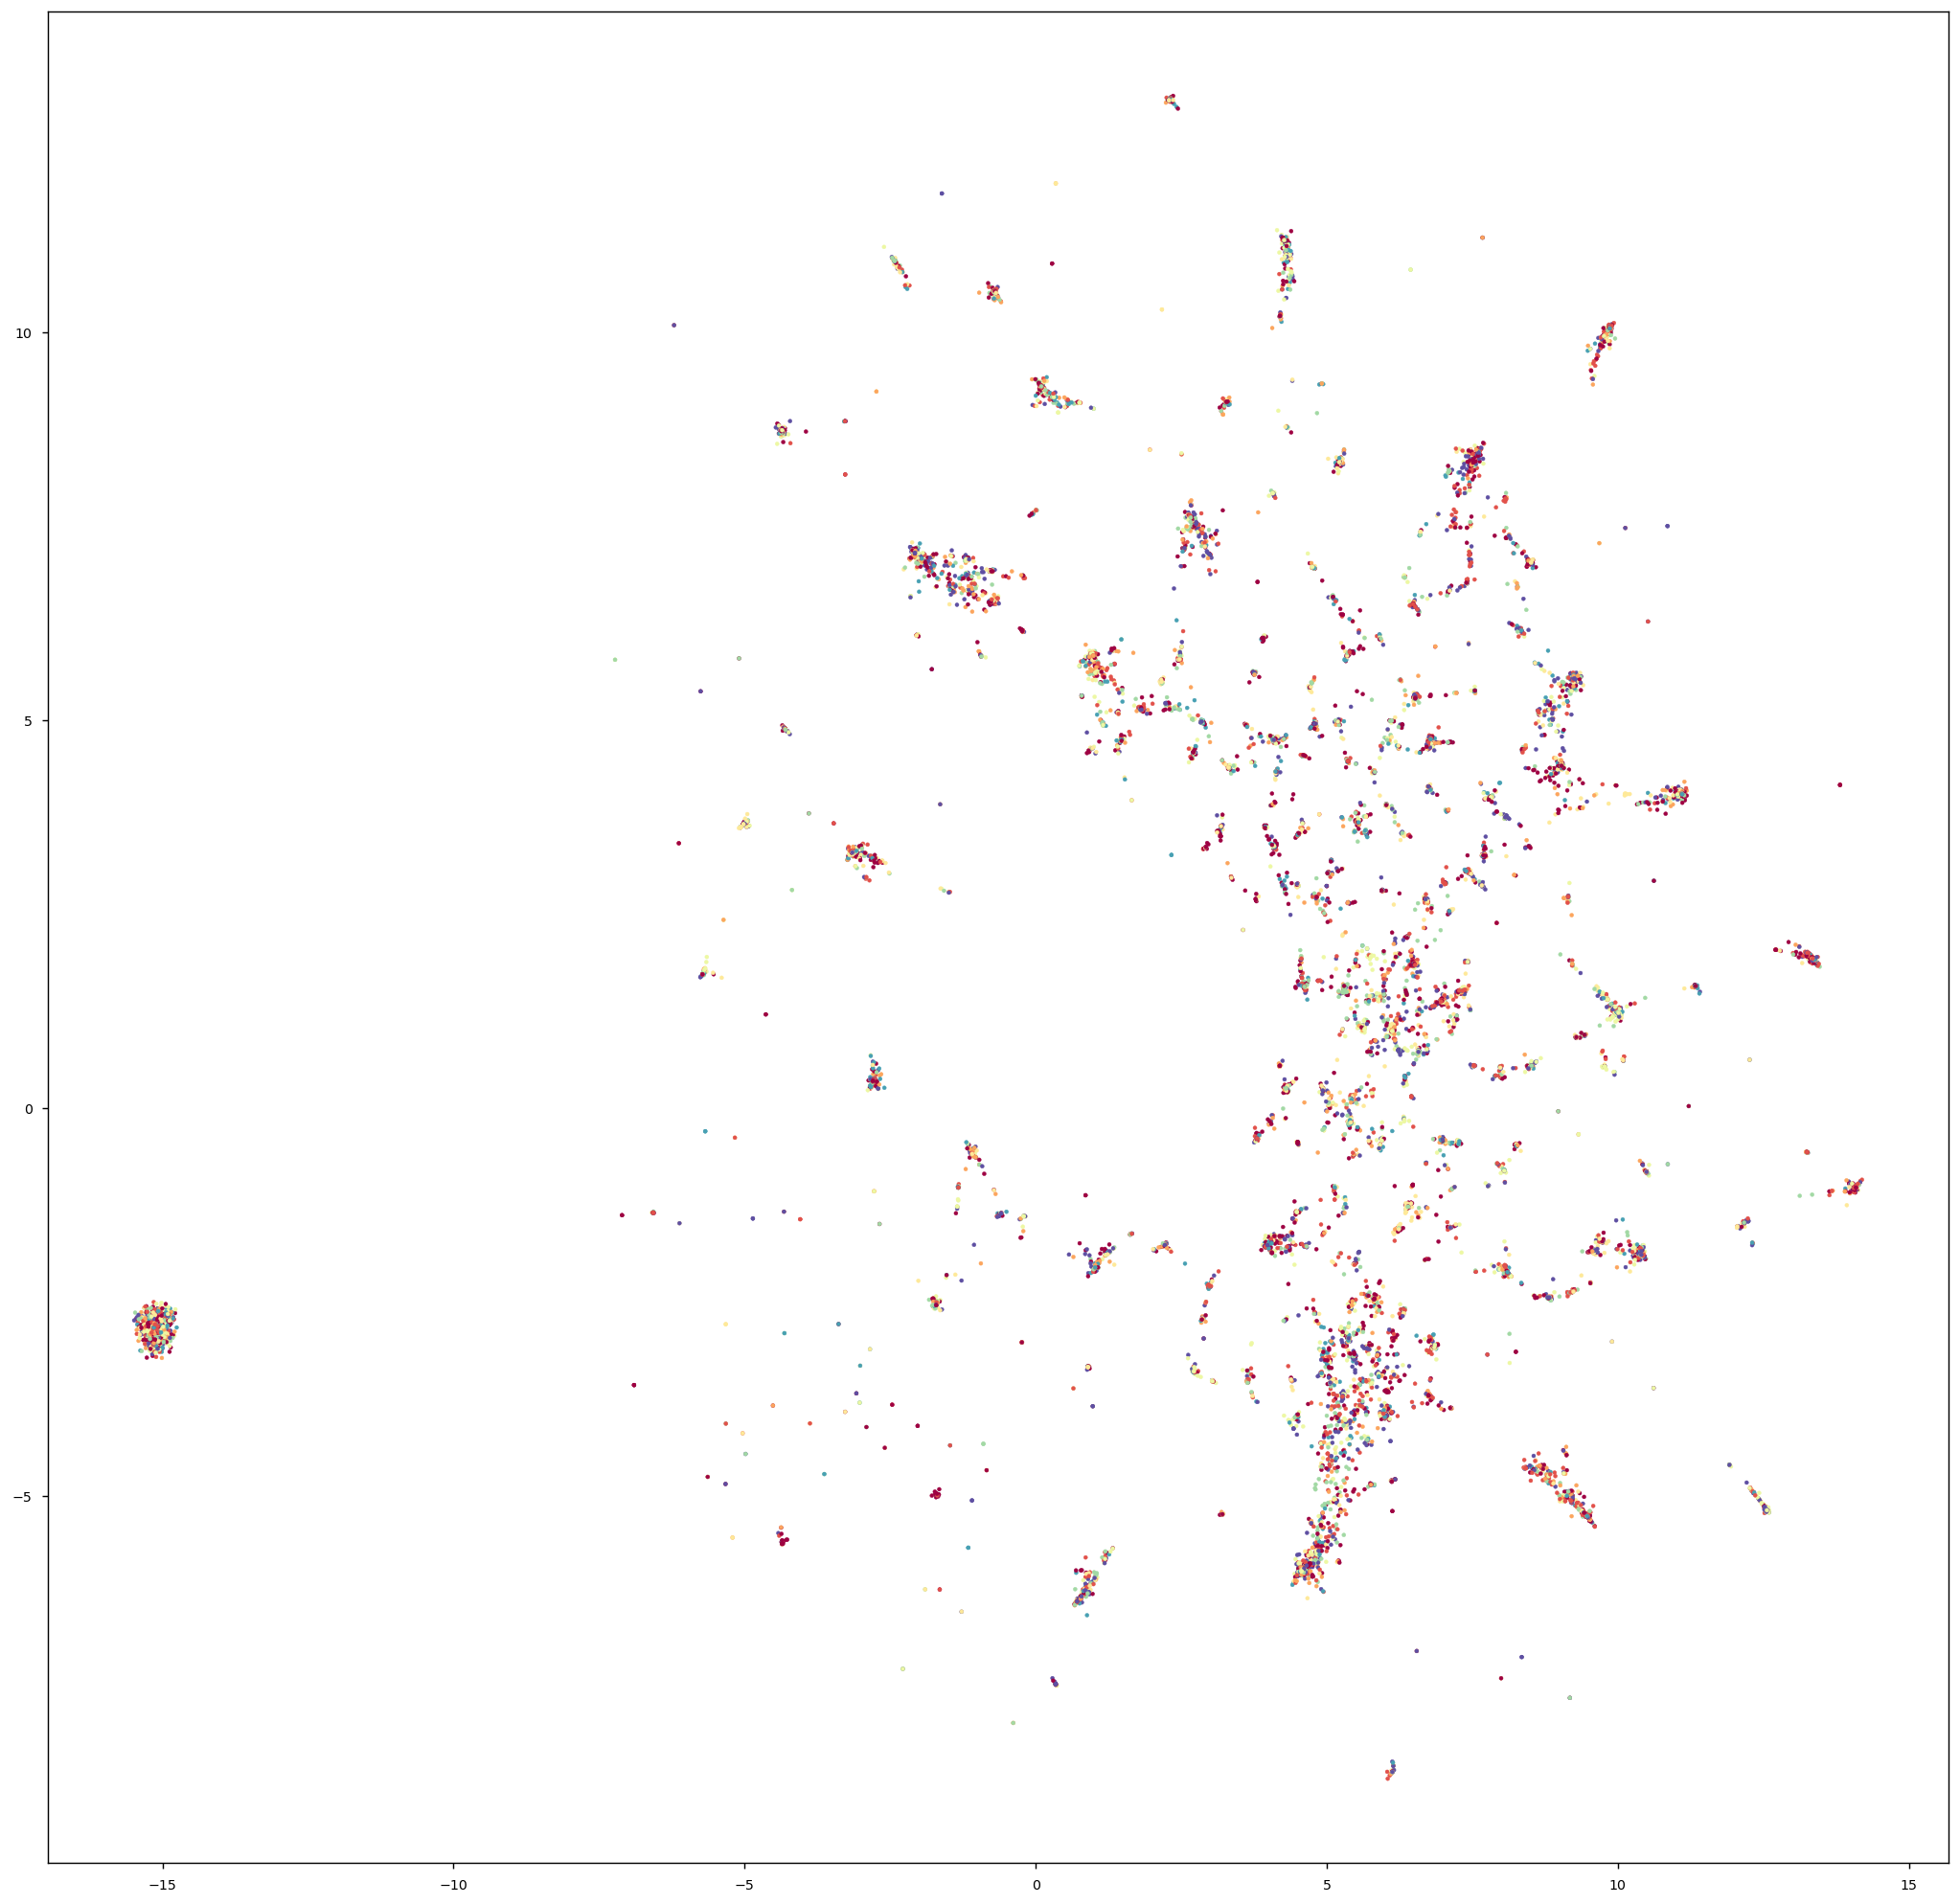

In [61]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(x=u_plot[0], y=u_plot[1], c=u_plot['label'], cmap='Spectral',\
           s=5, marker="o")


plt.show()

In [53]:
len(cv_umap.stop_words_)

4801

In [54]:
test_umap = cv_umap.transform(X_test)

In [55]:
test_embedding = umap.UMAP(n_components=2, metric='hellinger', 
                      min_dist=0.01, 
                      n_neighbors=35,).fit_transform(test_umap)

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 957854 edges.
It has only fully disconnected 25 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [56]:
u_plot2 = pd.DataFrame(test_embedding)
u_plot2['label'] = Y_test

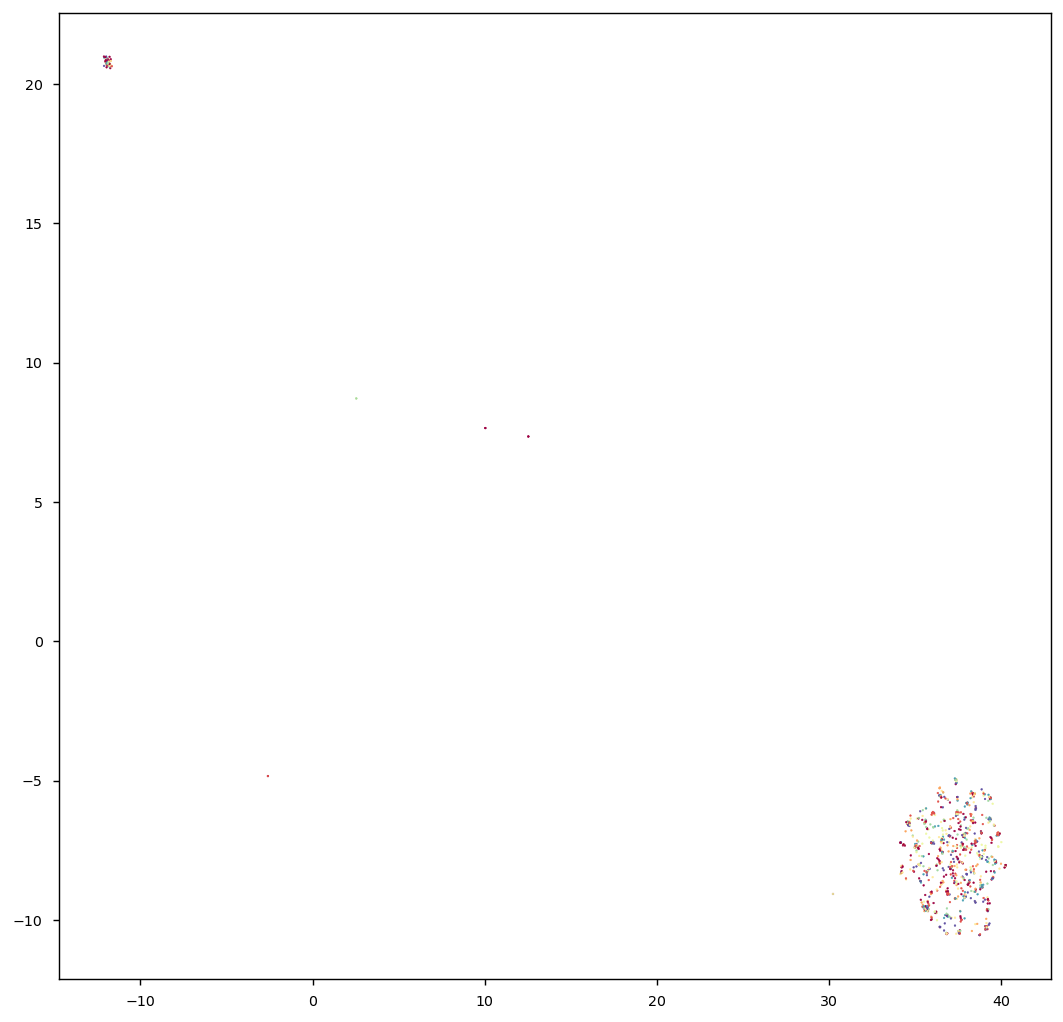

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=u_plot2[0], y=u_plot2[1], c=u_plot2['label'], cmap='Spectral',\
           s=1, marker="o")


plt.show()